In [8]:
import pandas as pd
import numpy as np

# 读取CSV文件并转换为numpy数组
def read_csv_to_numpy(file_path):
    # 使用pandas读取csv
    df = pd.read_csv(file_path)
    # 转换为numpy数组
    numpy_array = df.to_numpy()
    return numpy_array

# 使用示例
try:
    # 替换 'your_file.csv' 为你的CSV文件路径
    file_path = 'data.csv'
    arrayaaa = read_csv_to_numpy(file_path)
    print("数组形状:", arrayaaa.shape)
    print("数组内容:\n", arrayaaa)
except FileNotFoundError:
    print("文件未找到，请检查文件路径")
except Exception as e:
    print(f"发生错误: {e}")

数组形状: (477, 8)
数组内容:
 [[1.006e+03 9.960e+02 9.960e+02 ... 2.000e-01 0.000e+00 1.000e-02]
 [1.005e+03 9.960e+02 9.960e+02 ... 2.700e-01 0.000e+00 1.000e-02]
 [1.005e+03 9.950e+02 9.950e+02 ... 3.000e-01 0.000e+00 1.000e-02]
 ...
 [1.002e+03 9.940e+02 9.940e+02 ... 1.220e+00 1.670e+00 1.000e-02]
 [1.002e+03 9.950e+02 9.950e+02 ... 1.220e+00 1.670e+00 1.000e-02]
 [1.002e+03 9.940e+02 9.950e+02 ... 1.220e+00 1.670e+00 1.000e-02]]


In [21]:
import sys
sys.path.append("/root/autodl-tmp/pykan-master")
from kan import *
import torch
from kan import KAN, create_dataset
import pandas as pd
import numpy as np

# Device setup: Use GPU if available, otherwise fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create the KAN model and move it to the GPU
model = KAN(width=[5, 40,20, 1], grid=10, k=3, seed=1).to(device)

# Define a sample function and create a dataset (for demonstration)
f = lambda x: torch.exp((torch.sin(torch.pi * (x[:, [0]]**2 + x[:, [1]]**2)) + torch.sin(torch.pi * (x[:, [2]]**2 + x[:, [3]]**2))) / 2)
dataset = create_dataset(f, n_var=4, train_num=3000, device=device)

# Load and process the CSV data
df = pd.read_csv('dynamic_supply_chain_logistics_dataset.csv')

# Process timestamp: Convert to Unix timestamp (seconds since 1970)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df['timestamp'] = df['timestamp'].apply(lambda x: x.timestamp()).astype('float64')

# Process risk_classification: Map categories to numerical values
risk_map = {'Low Risk': 0.0, 'Moderate Risk': 0.5, 'High Risk': 1.0}
df['risk_classification'] = df['risk_classification'].map(risk_map).astype('float64')

# Convert DataFrame to NumPy array with float32 type
structured_array = df.to_numpy().astype(np.float32)

# Standardization function: Normalize along dimension 0
def normalize_along_dim0(tensor):
    mean = tensor.mean(dim=0)
    std = tensor.std(dim=0, unbiased=True)
    normalized_tensor = (tensor - mean) / (std + 1e-8)  # Add small constant to avoid division by zero
    return normalized_tensor

# Split data into train and test sets and move to GPU
# 原始输入
train_input = torch.from_numpy(arrayaaa[:, :5]).float().to(device)
test_input = torch.from_numpy(arrayaaa[-10:, :5]).float().to(device)



train_label = torch.from_numpy(arrayaaa[:, 5:6]).float().to(device)
test_label = torch.from_numpy(arrayaaa[-10:, 5:6]).float().to(device)

# col_to_remove = 2
# train_input = torch.cat((train_input[:, :col_to_remove], train_input[:, col_to_remove + 1:]), dim=1)
# test_input = torch.cat((test_input[:, :col_to_remove], test_input[:, col_to_remove + 1:]), dim=1)
# train_label = torch.from_numpy(structured_array[:10000, 2+1:2+2]).float().to(device)
# test_label = torch.from_numpy(structured_array[29000:, 2+1:2+2]).float().to(device)

# Normalize the data
# 计算训练集的均值和标准差
X_mean = train_input.mean(dim=0)  # 按列计算均值
X_std = train_input.std(dim=0)    # 按列计算标准差
y_mean = train_label.mean(dim=0)
y_std = train_label.std(dim=0)

# 标准化训练集和测试集
train_input = (train_input - X_mean) / X_std
test_input = (test_input - X_mean) / X_std  # 使用训练集的均值和标准差
train_label = (train_label - y_mean) / y_std
test_label = (test_label - y_mean) / y_std

# # 计算平方根
# train_input_sqrt = torch.sqrt(train_input+50)
# test_input_sqrt = torch.sqrt(test_input+50)

# # 沿着最后一个维度拼接
# train_input = torch.cat((train_input, train_input_sqrt), dim=-1)
# test_input = torch.cat((test_input, test_input_sqrt), dim=-1)

# print(train_label)

# Update dataset with processed data
dataset['train_input'] = train_input
dataset['test_input'] = test_input
dataset['train_label'] = train_label
dataset['test_label'] = test_label

# Print shapes to verify
print(dataset['train_input'].shape, dataset['test_input'].shape, dataset['train_label'].shape, dataset['test_label'].shape)

# Train the model on GPU
model.fit(dataset, opt="LBFGS", steps=100)

Using device: cuda
checkpoint directory created: ./model
saving model version 0.0
torch.Size([477, 5]) torch.Size([10, 5]) torch.Size([477, 1]) torch.Size([10, 1])


| train_loss: 1.93e-01 | test_loss: 3.36e-04 | reg: 8.27e+01 | : 100%|█| 100/100 [00:25<00:00,  3.93


saving model version 0.1


{'train_loss': [array(0.3685624, dtype=float32),
  array(0.21341221, dtype=float32),
  array(0.19488057, dtype=float32),
  array(0.19318189, dtype=float32),
  array(0.1927816, dtype=float32),
  array(0.19444402, dtype=float32),
  array(0.193058, dtype=float32),
  array(0.19279703, dtype=float32),
  array(0.19265653, dtype=float32),
  array(0.19260299, dtype=float32),
  array(0.19272509, dtype=float32),
  array(0.19261736, dtype=float32),
  array(0.1925995, dtype=float32),
  array(0.19259393, dtype=float32),
  array(0.19259144, dtype=float32),
  array(0.19260593, dtype=float32),
  array(0.19259225, dtype=float32),
  array(0.19259048, dtype=float32),
  array(0.19259009, dtype=float32),
  array(0.19259006, dtype=float32),
  array(0.19261526, dtype=float32),
  array(0.19259205, dtype=float32),
  array(0.19259065, dtype=float32),
  array(0.19259027, dtype=float32),
  array(0.19259004, dtype=float32),
  array(0.19259758, dtype=float32),
  array(0.19259073, dtype=float32),
  array(0.1925902, 

In [22]:
model = model.prune(edge_th=1e-2)
model = model.refine(20)
# model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=2.);
model.fit(dataset, opt="LBFGS", steps=100);

saving model version 0.2
saving model version 0.3


| train_loss: 2.99e-01 | test_loss: 1.14e-01 | reg: 4.04e+03 | : 100%|█| 100/100 [00:46<00:00,  2.13

saving model version 0.4


In [20]:

model = model.prune(edge_th=1e-2)
model = model.refine(30)
# model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=2.);
model.fit(dataset, opt="LBFGS", steps=100);

saving model version 0.5
saving model version 0.6


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 100/100 [01:01<00:00,  1.61it/s]

saving model version 0.7


In [8]:
model = model.prune(edge_th=5e-2)
model = model.refine(50)
# model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=2.);
model.fit(dataset, opt="LBFGS", steps=100);

saving model version 0.8
saving model version 0.9


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 100/100 [03:03<00:00,  1.83s/it]

saving model version 0.10


In [23]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.2818308174610138, c=1
fixing (0,0,1) with x, r2=0.44853025674819946, c=1
fixing (0,0,2) with x, r2=0.9852819442749023, c=1
fixing (0,0,3) with sin, r2=0.9728203415870667, c=2
fixing (0,0,4) with x, r2=0.8053977489471436, c=1
fixing (0,0,5) with x, r2=0.9089985489845276, c=1
fixing (0,0,6) with x, r2=0.9290177226066589, c=1
fixing (0,0,7) with x, r2=0.7746257185935974, c=1
fixing (0,0,8) with x, r2=0.9141823053359985, c=1
fixing (0,0,9) with tan, r2=0.9982480406761169, c=3
fixing (0,0,10) with x^2, r2=0.9993886947631836, c=2
fixing (0,0,11) with x, r2=0.5591776371002197, c=1
fixing (0,0,12) with x, r2=0.943931519985199, c=1
fixing (0,0,13) with x, r2=0.6767109632492065, c=1
fixing (0,0,14) with x, r2=0.980170726776123, c=1
fixing (0,0,15) with x, r2=0.995500922203064, c=1
fixing (0,0,16) with x, r2=0.8668126463890076, c=1
fixing (0,0,17) with sin, r2=0.9974220991134644, c=2
fixing (0,0,18) with sin, r2=0.9881166815757751, c=2
fixing (0,0,19) with x^2, r2=0.99

-0.0247*x_1 + 0.0605*x_2 - 0.0081*x_4 - 0.0081*x_5 - 0.0004*(-0.72*x_1 - 1)**2 - 1.0696*(-x_3 - 0.1)**4 + 0.0924*(-x_4 - 0.3935)**2 + 0.0223*(-0.8021*x_5 - 1)**2 + 0.0495*(-0.7446*x_5 - 1)**2 - 0.0009*(0.04*x_1 + 0.2317*x_2 + sin(5.5626*x_5 - 0.0402) - 0.0004*tan(0.0602*x_4 - 4.6781) - 0.2236)**2 + 0.0027*(0.0969*x_1 - 0.5973*x_2 + 0.4732*x_4 + 0.6033*sin(5.394*x_5 + 5.9806) - 1)**2 + 0.0047*(-0.0524*x_1 - 0.137*x_2 - 0.7267*x_4 - sin(7.0875*x_5 - 7.0972) - 0.0004*tan(2.2246*x_3 + 5.5345) - 0.3922)**2 + 0.001*(-0.0524*x_1 - 0.137*x_2 - 0.7267*x_4 - sin(7.0875*x_5 - 7.0972) - 0.0004*tan(2.2246*x_3 + 5.5345) - 0.2529)**2 - 0.005*(0.1784*x_1 + 0.0303*x_2 + 0.3319*sin(6.3374*x_5 - 1.8702) + 0.0002*tan(0.6006*x_3 + 1.7429) + 1 + 0.0011*exp(-4.7229*x_4))**4 - 0.6445*(0.0272*x_2 + (-x_4 - 0.3935)**2 + 0.2412*(-0.8021*x_5 - 1)**2 - 0.0147*sin(3.0742*x_1 - 2.8603) - 0.086 + 0.0102*exp(-3.6479*x_3))**2 + 2.0568*(0.0272*x_2 + (-x_4 - 0.3935)**2 + 0.2412*(-0.8021*x_5 - 1)**2 - 0.0147*sin(3.0742*x_

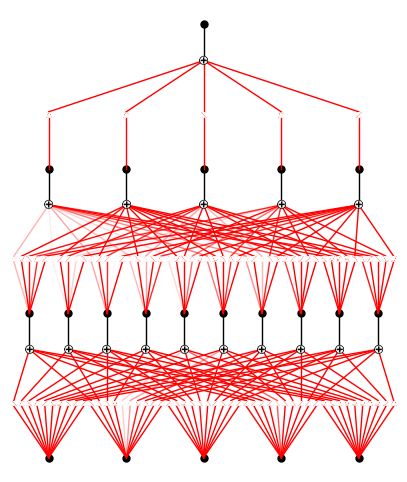

In [16]:

model.plot()

In [17]:
model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: nan | test_loss: nan | reg: 0.00e+00 | :   3%|▏       | 3/100 [00:12<06:36,  4.08s/it]


KeyboardInterrupt: 

In [24]:
formula = model.symbolic_formula()[0][0]
print(ex_round(formula, 6))
ex_round(formula, 6)

-0.024707*x_1 + 0.060479*x_2 - 0.008116*x_4 - 0.008099*x_5 - 0.000386*(-0.720016*x_1 - 1)**2 - 1.069615*(-x_3 - 0.100003)**4 + 0.092371*(-x_4 - 0.393469)**2 + 0.022279*(-0.802057*x_5 - 1)**2 + 0.049451*(-0.744589*x_5 - 1)**2 + 0.0047*(-0.052414*x_1 - 0.137009*x_2 - 0.726669*x_4 - sin(7.08752*x_5 - 7.0972) - 0.000365*tan(2.22456*x_3 + 5.53448) - 0.392238)**2 + 0.000996*(-0.052414*x_1 - 0.137009*x_2 - 0.726669*x_4 - sin(7.08752*x_5 - 7.0972) - 0.000365*tan(2.22456*x_3 + 5.53448) - 0.252908)**2 - 0.000907*(0.04004*x_1 + 0.231653*x_2 + sin(5.56264*x_5 - 0.04016) - 3.0e-6*tan(9.03784*x_3 + 4.4125599861145) - 0.000424*tan(0.06016*x_4 - 4.67808) - 0.223634)**2 + 0.002658*(0.096895*x_1 - 0.597293*x_2 + 0.473211*x_4 + 0.603262*sin(5.394*x_5 + 5.980639) + 2.9e-5*tan(0.212*x_3 - 4.65312) - 1)**2 - 0.005017*(0.178432*x_1 + 0.030289*x_2 + 0.331913*sin(6.33744*x_5 - 1.87024) + 0.000155*tan(0.60064*x_3 + 1.74288) + 1 + 0.00115*exp(-4.72288*x_4))**4 - 0.644477*(0.027221*x_2 + (-x_4 - 0.393469)**2 + 0.

-0.024707*x_1 + 0.060479*x_2 - 0.008116*x_4 - 0.008099*x_5 - 0.000386*(-0.720016*x_1 - 1)**2 - 1.069615*(-x_3 - 0.100003)**4 + 0.092371*(-x_4 - 0.393469)**2 + 0.022279*(-0.802057*x_5 - 1)**2 + 0.049451*(-0.744589*x_5 - 1)**2 + 0.0047*(-0.052414*x_1 - 0.137009*x_2 - 0.726669*x_4 - sin(7.08752*x_5 - 7.0972) - 0.000365*tan(2.22456*x_3 + 5.53448) - 0.392238)**2 + 0.000996*(-0.052414*x_1 - 0.137009*x_2 - 0.726669*x_4 - sin(7.08752*x_5 - 7.0972) - 0.000365*tan(2.22456*x_3 + 5.53448) - 0.252908)**2 - 0.000907*(0.04004*x_1 + 0.231653*x_2 + sin(5.56264*x_5 - 0.04016) - 3.0e-6*tan(9.03784*x_3 + 4.4125599861145) - 0.000424*tan(0.06016*x_4 - 4.67808) - 0.223634)**2 + 0.002658*(0.096895*x_1 - 0.597293*x_2 + 0.473211*x_4 + 0.603262*sin(5.394*x_5 + 5.980639) + 2.9e-5*tan(0.212*x_3 - 4.65312) - 1)**2 - 0.005017*(0.178432*x_1 + 0.030289*x_2 + 0.331913*sin(6.33744*x_5 - 1.87024) + 0.000155*tan(0.60064*x_3 + 1.74288) + 1 + 0.00115*exp(-4.72288*x_4))**4 - 0.644477*(0.027221*x_2 + (-x_4 - 0.393469)**2 + 0.

In [ ]:
0.0065185404*x_1 - 0.0015733551*x_2 + 0.0023067647*x_3 - 0.0002042616*x_5 + 0.0093320001*x_6 - 0.0015581805*x_7 + 0.0099164573*x_8 + 0.001312092*(0.7166879818 - x_4)**2 + 0.0022884607*(0.7406031193 - x_4)**2 + 0.0009999082*(-0.819869655*x_4 - 1)**2 + 46.6913477541*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2272191467 - exp(-0.2109505087*x_4))**2 + 0.5937337504*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2272989253 - exp(-0.2109505087*x_4))**2 - 47.6681848878*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2281913227 - exp(-0.2109505087*x_4))**2 + 0.4300457254*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2307012479 - exp(-0.2109505087*x_4))**2 + 0.0285281814*exp(0.670906961*x_4) + 0.0060065173 - 2.12668e-5*exp(-2.2581598759*x_4) - 0.1950089176*exp(-0.2109505087*x_4)

In [20]:
ex_round(model, 3)

model_output = model(dataset['train_input'])

# model_output_old = model_output * y_std + y_mean
model_output = model_output * y_std + y_mean




# print(model_output)
print(model_output.shape)
print('kan  MSE:', torch.mean((model_output - dataset['train_label'])**2))
print('TKEB MSE:', torch.mean((torch.from_numpy(np_label_1.astype(np.float32)).cpu()[:200] - torch.abs(dataset['train_label']))**2))
#print(torch.abs(model_output))

torch.Size([477, 1])
kan  MSE: tensor(3.3293, device='cuda:0', grad_fn=<MeanBackward0>)


NameError: name 'np_label_1' is not defined

In [23]:
concatenated_array = np.concatenate((model_output_old.cpu().detach().numpy(), model_output.cpu().detach().numpy()), axis=1)

# Save the concatenated array to a .npy file
np.save('kan_xy.npy', concatenated_array)

[3.9561803 2.5449977 3.31858   1.9462346 2.4695475 3.2688653 2.6934214
 3.034635  2.2688313 3.6426177 1.7455016 4.214014  2.836995  2.7289474
 2.313555  3.5497622 3.6403568 1.4638828 3.0929003 2.5781507 2.3685868]


Text(0, 0.5, 'feature attribution score')

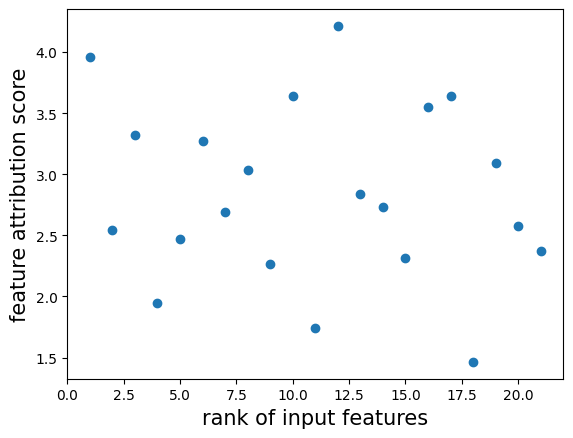

In [7]:
print(model.feature_score.cpu().detach().numpy())
import matplotlib.pyplot as plt
plt.scatter(np.arange(21)+1, model.feature_score.cpu().detach().numpy())
plt.xlabel('rank of input features', fontsize=15)
plt.ylabel('feature attribution score', fontsize=15)

In [146]:
model_output = model(dataset['train_input'])
print(model_output)

tensor([[ 0.0010],
        [-0.0018],
        [ 0.0097],
        [ 0.0005],
        [-0.0071],
        [ 0.0014],
        [-0.0167],
        [-0.0006],
        [ 0.0202],
        [ 0.0119],
        [ 0.0043],
        [ 0.0081],
        [ 0.0189],
        [ 0.0216],
        [ 0.0187],
        [ 0.0080],
        [ 0.0143],
        [-0.0025],
        [ 0.0230],
        [ 0.0166],
        [ 0.0070],
        [-0.0019],
        [ 0.0109],
        [ 0.0096],
        [ 0.0200],
        [ 0.0046],
        [ 0.0011],
        [ 0.0265],
        [ 0.0086],
        [ 0.0133],
        [ 0.0186],
        [ 0.0006],
        [ 0.0368],
        [ 0.0049],
        [-0.0046],
        [ 0.0361],
        [ 0.0106],
        [ 0.0261],
        [ 0.0047],
        [ 0.0112],
        [ 0.0319],
        [ 0.0485],
        [ 0.0159],
        [ 0.0093],
        [ 0.0257],
        [ 0.0169],
        [ 0.0148],
        [ 0.0163],
        [ 0.0413],
        [ 0.0234],
        [ 0.0097],
        [ 0.0179],
        [ 0.

In [57]:
grids = [5,10,20,50]
#grids = [5]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    #model = KAN(width=[4,2,1,1], grid=grids[i], k=3, seed=0, device=device).initialize_from_another_model(model, dataset['train_input'])
    model = model.refine(grids[i])
    results = model.fit(datasemodel = model.refine(10)
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())

saving model version 0.3


| train_loss: 1.31e+10 | test_loss: 1.44e+10 | reg: 5.44e+06 | : 100%|█| 50/50 [00:01<00:00, 47.79it


saving model version 0.4
saving model version 0.5


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:01<00:00, 42.57it/s]


saving model version 0.6
saving model version 0.7


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:01<00:00, 35.41it/s]


saving model version 0.8
saving model version 0.9


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:02<00:00, 21.24it/s]


saving model version 0.10
